In [1]:
from fastai.tabular.all import *
from transfertab.utils import *
from transfertab.transfer import *
from transfertab.extract import *
from fastcore.xtras import *
from fastai.learner import *
import torch
import numpy as np
from fastai.interpret import *

In [4]:
import pandas as pd
df = pd.read_csv("bank-additional-full.csv", delimiter=';')

In [20]:
import wandb
from fastai.callback.wandb import *

In [6]:
df.shape

(41188, 21)

In [8]:
41188 * 0.7

28831.6

In [9]:
dfA = df.iloc[0:28831]
dfB = df.iloc[28831:-1]

In [10]:
dfA.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [12]:
contcols = ['age', 'duration', 'campaign', 'pdays',
       'previous', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed']
catcols = ['job', 'marital', 'education', 'default', 'housing', 'loan','contact', 
	'month', 'day_of_week','poutcome']
target = 'y'

In [24]:
splitsA = RandomSplitter(valid_pct=0.2)(range_of(dfA))
toA = TabularPandas(dfA, procs=[Categorify, FillMissing, Normalize],
                   cat_names=catcols,
                   cont_names=contcols,
                   y_names=target,
                   splits=splitsA)
dlsA = toA.dataloaders(bs=512)
learnA = tabular_learner(dlsA, metrics=accuracy)

In [25]:
cbs=[WandbCallback(log="all", dataset_name="bank-additional-full (first .7)", n_preds=128, seed=1), SaveModelCallback()]
learnA.fit_one_cycle(50, cbs=cbs)

epoch,train_loss,valid_loss,accuracy,time
0,0.749303,0.649875,0.763094,00:02
1,0.718157,0.684830,0.789109,00:06
2,0.692475,0.654220,0.857614,00:06
3,0.661029,0.621325,0.871315,00:06
4,0.612372,0.545851,0.903746,00:06
5,0.530301,0.415358,0.939473,00:06
6,0.413513,0.269495,0.944676,00:06
7,0.294984,0.184901,0.953174,00:06
8,0.213285,0.155507,0.945890,00:06
9,0.166619,0.147200,0.942768,00:06


Better model found at epoch 0 with valid_loss value: 0.6498745679855347.
Better model found at epoch 3 with valid_loss value: 0.6213252544403076.
Better model found at epoch 4 with valid_loss value: 0.5458512306213379.
Better model found at epoch 5 with valid_loss value: 0.415358304977417.
Better model found at epoch 6 with valid_loss value: 0.269494891166687.
Better model found at epoch 7 with valid_loss value: 0.1849014014005661.
Better model found at epoch 8 with valid_loss value: 0.15550671517848969.
Better model found at epoch 9 with valid_loss value: 0.1471996009349823.
Better model found at epoch 10 with valid_loss value: 0.12473147362470627.
Better model found at epoch 11 with valid_loss value: 0.12259650230407715.
Better model found at epoch 12 with valid_loss value: 0.11823393404483795.
Better model found at epoch 14 with valid_loss value: 0.11515449732542038.
Better model found at epoch 15 with valid_loss value: 0.1147831529378891.
Better model found at epoch 17 with valid_l

In [21]:
wandb.init(
    project='transfertab', 
    save_code=True, 
    group='Exp4c', 
    job_type='basetrain', 
    tags=['base', 'bank'], 
    name='modelA training',
    notes="Training modelA from which we'll take embeddings",
    reinit=True
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: manikya (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


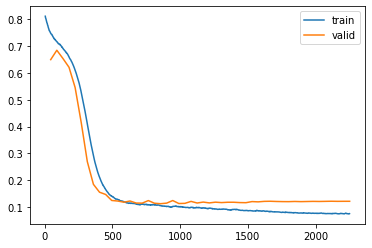

In [26]:
learnA.recorder.plot_loss()

In [27]:
torch.save(learnA.model.state_dict(),"modelA_state_dict")

In [28]:
catdict = {col:list(learnA.dls.categorify.classes[col]) for col in catcols}

In [33]:
embeds = extractembeds(learnA.model, catdict, transfercats=catcols, allcats=catcols, path="learnA_extracts", kind="json")

In [30]:
wandb.finish()

epoch,50
train_loss,0.07543
raw_loss,0.09526
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,1e-05
_runtime,358
_timestamp,1634734110
_step,2249


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,██▇▇▆▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,█▇█▇▅▄▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▃▄▅▆▇███████▇▇▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


In [31]:
splitsB = RandomSplitter(valid_pct=0.2)(range_of(dfB))
toB = TabularPandas(dfB, procs=[Categorify, FillMissing, Normalize],
                   cat_names = catcols,
                   cont_names = contcols,
                   y_names=target,
                   splits=splitsB)
dlsB = toB.dataloaders(bs=256)

In [32]:
learnB = tabular_learner(dlsB, metrics=accuracy, emb_szs={'default':4, 'month':12})

In [36]:
# catdict = getcatdict(df, catcols)
metadict = {}
for (cat, classes) in catdict.items():
	metadict[cat] = {'mapped_cat': cat, 'classes_info': {clas: clas for clas in classes}}
with open('bank_meta.json', 'w') as fp:
	json.dump(metadict, fp)

In [50]:
metadict={"job": {"mapped_cat": "job", "classes_info": {"#na#": "#na#", "admin.": "admin.", "blue-collar": "blue-collar", "entrepreneur": "entrepreneur", "housemaid": "housemaid", "management": "management", "retired": "retired", "self-employed": "self-employed", "services": "services", "student": "student", "technician": "technician", "unemployed": "unemployed", "unknown": "unknown"}}, "marital": {"mapped_cat": "marital", "classes_info": {"#na#": "#na#", "divorced": "divorced", "married": "married", "single": "single", "unknown": "unknown"}}, "education": {"mapped_cat": "education", "classes_info": {"#na#": "#na#", "basic.4y": "basic.4y", "basic.6y": "basic.6y", "basic.9y": "basic.9y", "high.school": "high.school", "illiterate": "illiterate", "professional.course": "professional.course", "university.degree": "university.degree", "unknown": "unknown"}}, "default": {"mapped_cat": "default", "classes_info": {"#na#": "#na#", "no": "no", "unknown": "unknown"}}, "housing": {"mapped_cat": "housing", "classes_info": {"#na#": "#na#", "no": "no", "unknown": "unknown", "yes": "yes"}}, "loan": {"mapped_cat": "loan", "classes_info": {"#na#": "#na#", "no": "no", "unknown": "unknown", "yes": "yes"}}, "contact": {"mapped_cat": "contact", "classes_info": {"#na#": "#na#", "cellular": "cellular", "telephone": "telephone"}}, "month": {"mapped_cat": "month", "classes_info": {"#na#": "#na#", "apr": "apr", "aug": "aug", "dec": "dec", "jul": "jul", "jun": "jun", "mar": "mar", "may": "may", "nov": "nov", "oct": "oct", "sep":[]}}, "day_of_week": {"mapped_cat": "day_of_week", "classes_info": {"#na#": "#na#", "fri": "fri", "mon": "mon", "thu": "thu", "tue": "tue", "wed": "wed"}}, "poutcome": {"mapped_cat": "poutcome", "classes_info": {"#na#": "#na#", "failure": "failure", "nonexistent": "nonexistent", "success": "success"}}}

In [46]:
learnB.dls.categorify['month']

['#na#', 'apr', 'aug', 'dec', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep']

In [47]:
learnA.dls.categorify['month']

['#na#', 'apr', 'aug', 'dec', 'jul', 'jun', 'mar', 'may', 'nov', 'oct']

In [39]:
learnA.model.embeds

ModuleList(
  (0): Embedding(13, 7)
  (1): Embedding(5, 4)
  (2): Embedding(9, 5)
  (3): Embedding(4, 3)
  (4): Embedding(4, 3)
  (5): Embedding(4, 3)
  (6): Embedding(3, 3)
  (7): Embedding(10, 6)
  (8): Embedding(6, 4)
  (9): Embedding(4, 3)
)

In [40]:
learnB.model.embeds

ModuleList(
  (0): Embedding(13, 7)
  (1): Embedding(5, 4)
  (2): Embedding(9, 5)
  (3): Embedding(3, 3)
  (4): Embedding(4, 3)
  (5): Embedding(4, 3)
  (6): Embedding(3, 3)
  (7): Embedding(11, 6)
  (8): Embedding(6, 4)
  (9): Embedding(4, 3)
)

In [41]:
learnB.dls.cat_names

(#10) ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']

In [52]:
catcols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [55]:
transfercats = ['job',
 'marital',
 'education',
#  'default',
 'housing',
 'loan',
 'contact',
#  'month',
 'day_of_week',
 'poutcome']

In [68]:
# transfer_cats = (" workclass", " marital_status", " race", " relationship", " education")
# catcolsB = tuple(learnB.dls.cat_names)
# catdictB = {col:list(learnB.dls.categorify.classes[col]) for col in catcolsB}
transferembeds_(
    learnB.model.embeds, 
    learnA.model.embeds, 
    metadict, 
    transfercats, 
    newcatcols=catcols, 
    oldcatcols=catcols, 
    oldcatdict=catdict, 
    newcatdict=catdict)

In [69]:
learnA.model.embeds[catcols.index('marital')].weight

Parameter containing:
tensor([[-0.0062, -0.0045,  0.0040,  0.0023],
        [ 0.0453, -0.0868, -0.0149, -0.1187],
        [-0.0988,  0.0682, -0.0179,  0.0305],
        [ 0.0457, -0.0005,  0.0830,  0.0363],
        [ 0.0554, -0.0514,  0.0081,  0.0404]], requires_grad=True)

In [70]:
learnB.model.embeds[catcols.index('marital')].weight

Parameter containing:
tensor([[-0.0062, -0.0045,  0.0040,  0.0023],
        [ 0.0453, -0.0868, -0.0149, -0.1187],
        [-0.0988,  0.0682, -0.0179,  0.0305],
        [ 0.0457, -0.0005,  0.0830,  0.0363],
        [ 0.0554, -0.0514,  0.0081,  0.0404]])

In [71]:
dlsC = deepcopy(dlsB)
learnC = tabular_learner(dlsC, metrics=accuracy)

In [72]:
learnC.model.layers.load_state_dict(learnB.model.layers.state_dict())

<All keys matched successfully>

In [67]:
wandb.init(
    project='transfertab', 
    save_code=True, 
    group='Exp4c', 
    job_type='finetune', 
    tags=['transfer', 'bank'], 
    name='modelB training v2',
    notes='Training modelB which contains transferred embeddings',
    reinit=True
)

wandb: wandb version 0.12.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [73]:
for i in range(len(catcols)):
    learnB.model.embeds[i].weight.requires_grad = False
learnB.create_opt()

In [74]:
learnB.embeds[5].weight

Parameter containing:
tensor([[-0.0033,  0.0035,  0.0032],
        [-0.0743, -0.0636, -0.0740],
        [ 0.0381, -0.0166, -0.0233],
        [ 0.0215,  0.1490,  0.0855]])

In [75]:
cbsB=[WandbCallback(log="all", dataset_name="bank 0.3%", n_preds=128, seed=1), SaveModelCallback()]
learnB.fit_one_cycle(3, cbs=cbsB)

epoch,train_loss,valid_loss,accuracy,time
0,0.328638,0.355238,0.825172,00:00
1,0.328883,0.344652,0.830028,00:07
2,0.321108,0.342023,0.831647,00:09


Better model found at epoch 0 with valid_loss value: 0.35523781180381775.
Better model found at epoch 1 with valid_loss value: 0.3446517884731293.
Better model found at epoch 2 with valid_loss value: 0.3420228660106659.


In [76]:
for i in range(len(catcols)):
    learnB.model.embeds[i].weight.requires_grad = True
learnB.create_opt()

In [77]:
learnB.fit_one_cycle(5, cbs=cbsB)

epoch,train_loss,valid_loss,accuracy,time
0,0.315563,0.343439,0.830028,00:00
1,0.323050,0.350047,0.830433,00:06
2,0.317710,0.346990,0.828410,00:06
3,0.311835,0.347382,0.828814,00:06
4,0.303627,0.345026,0.826791,00:07


Better model found at epoch 0 with valid_loss value: 0.3434385359287262.


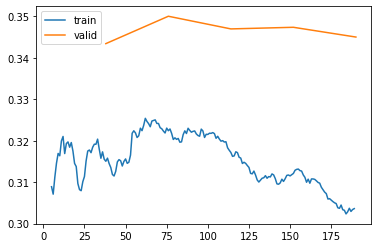

In [78]:
learnB.recorder.plot_loss()

In [79]:
wandb.finish()

epoch,8
train_loss,0.30363
raw_loss,0.31384
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.94999
eps_0,1e-05
_runtime,147
_timestamp,1634735947
_step,304


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,▅▅█▆▅▅▅▅▅▅▅▅▄▄▄▂▃▄▂▄▃▃▄▄▄▄▄▄▄▄▃▃▂▂▂▂▂▁▁▁
raw_loss,▆▅▃▅▆▆▆▅▅▄▅█▄▂▅▄▆▆▆▇▃▆▃▄▄▄▄▃▆▅▇▄▆▂▅▄▄▁▆▅
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▅▇██▇▆▆▅▄▃▂▁▁▁▂▃▅▇████▇▇▇▆▆▅▅▄▃▃▂▂▂▁▁▁
mom_0,█▇▄▂▁▁▂▃▃▄▅▆▇███▇▆▄▂▁▁▁▁▂▂▂▃▃▄▄▅▆▆▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [80]:
wandb.init(
    project='transfertab', 
    save_code=True, 
    group='Exp4c', 
    job_type='controlgrp', 
    tags=['base', 'bank'], 
    name='modelC training',
    notes='Training modelC which contains randomly initialized weights and same classifier weights as modelB',
    reinit=True
)

wandb: wandb version 0.12.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [81]:
cbsC=[WandbCallback(log="all", dataset_name="bank 0.3%", n_preds=128, seed=1), SaveModelCallback()]
learnC.fit_one_cycle(8, cbs=cbsC)

epoch,train_loss,valid_loss,accuracy,time
0,0.340277,0.344428,0.828005,00:00
1,0.340781,0.344436,0.834480,00:06
2,0.339190,0.340990,0.834075,00:06
3,0.332897,0.343881,0.830028,00:06
4,0.325089,0.339312,0.826386,00:06
5,0.319079,0.338450,0.829624,00:06
6,0.310707,0.338733,0.831242,00:06
7,0.307590,0.339051,0.832456,00:06


Better model found at epoch 0 with valid_loss value: 0.3444281816482544.
Better model found at epoch 2 with valid_loss value: 0.34098973870277405.
Better model found at epoch 4 with valid_loss value: 0.3393116891384125.
Better model found at epoch 5 with valid_loss value: 0.33844953775405884.


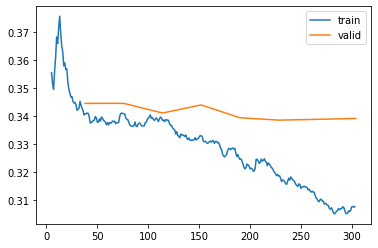

In [82]:
learnC.recorder.plot_loss()

In [83]:
wandb.finish()

epoch,8
train_loss,0.30759
raw_loss,0.31709
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,1e-05
_runtime,102
_timestamp,1634736066
_step,303


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,▆▆█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
raw_loss,▇▅▄▄▆▆▆▅▅▅▄█▅▃▇▆▅▄▄▃▄▆▂▇▁▃▃▅▂▂▁▂▃▄▄▂▃▅▃▄
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▃▄▅▆▇████████▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▇▅▄▃▂▁▁▁▁▁▁▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
